## Import training/test files in Pandas

In [1]:
import pandas as pd
import os 

print(os.getcwd())

/home/ubuntu/Desktop/multi-task-learning


In [2]:
train_data = pd.read_csv(os.path.join(os.getcwd() + '/data/training_csv'))
test_data = pd.read_csv(os.path.join(os.getcwd() + '/data/test_csv'))

In [3]:
# Note: we are enabling eager execution for debugging!

import numpy as np
import tensorflow as tf
tf.enable_eager_execution()

/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/mondeique/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/anaconda3/envs/mondeique

In [4]:
# Example code for handling datasets
import matplotlib.pyplot as plt

# Load filenames and labels
filenames = tf.constant(train_data.iloc[:, 0].tolist())
labels = tf.constant(train_data.iloc[:, 1:].values)

# Add to a dataset object
dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

# We can debug using eager execution
for img, labels in dataset.batch(4).take(1):
    print(img)
    print(labels)

tf.Tensor(
[b'./data/cropped-bag-images-dev/5O2BQILGU6S_1.jpg'
 b'./data/cropped-bag-images-dev/X63VMOKHOQY_1.jpg'
 b'./data/cropped-bag-images-dev/TGEWLADRYBR_1.jpg'
 b'./data/cropped-bag-images-dev/SQJAPKTWWFJ_2.jpg'], shape=(4,), dtype=string)
tf.Tensor(
[[1]
 [4]
 [9]
 [1]], shape=(4, 1), dtype=int64)


In [5]:
# Reads an image from a file, decodes it into a dense tensor, and resizes it
# to a fixed shape.

def _parse_function(filename, label):
    print(filename)
    image_string = tf.read_file(filename) 
    print(image_string)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3) # Channels needed because some test images are b/w
    image_resized = tf.image.resize_images(image_decoded, [160, 160])
    image_shape = tf.cast(tf.shape(image_decoded), tf.float32)
#     label = tf.concat([label[:]], axis=0)
    return {"x": image_resized}, label

## Make Dataset

In [6]:
# This snippet is adapted from here: https://www.tensorflow.org/guide/datasets
def input_fn(dataframe, is_eval=False):

    # Load the list of files
    filenames = tf.constant(dataframe.iloc[:, 0].tolist())

    # Load the labels
    labels = tf.constant(dataframe.iloc[:, 1:].values)

    # Build the dataset with image processing on top of it
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(_parse_function)

    # Add shuffling and repeatition if training
    if is_eval:
        dataset = dataset.batch(64)
    else:
        dataset = dataset.repeat().shuffle(1000).batch(64)

    return dataset

Tensor("args_0:0", shape=(), dtype=string)
Tensor("ReadFile:0", shape=(), dtype=string)
tf.Tensor([1], shape=(1,), dtype=int64)
tf.Tensor([4], shape=(1,), dtype=int64)


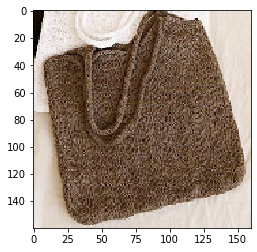

In [7]:
# Check the image & some labels
import matplotlib.pyplot as plt
for (imgs, labels) in input_fn(train_data, is_eval=True).take(1):
    plt.imshow(imgs['x'][0] / 255)
    print(labels[0])
    print(labels[1])

## Standard classical estimator (single-task only!)

### Reimplement the feature extraction from the original paper

In [8]:
def extract_features(features):
    # Input layer
    input_layer = tf.reshape(features["x"], [-1, 160, 160, 3])

    # First convolutive layer
    conv1 = tf.layers.conv2d(inputs=input_layer, filters=16, kernel_size=[5, 5], padding="same", activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Second convolutive layer
    conv2 = tf.layers.conv2d(inputs=pool1, filters=48, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Third convolutive layer
    conv3 = tf.layers.conv2d(inputs=pool2, filters=64, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)
    
    # Fourth convolutive layer
    conv4 = tf.layers.conv2d(inputs=pool3, filters=64, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    pool4 = tf.layers.max_pooling2d(inputs=conv4, pool_size=[2, 2], strides=2)
    
    # Fifth convolutive layer
    conv5 = tf.layers.conv2d(inputs=pool4, filters=128, kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
    pool5 = tf.layers.max_pooling2d(inputs=conv5, pool_size=[2, 2], strides=2)

    # Fourth convolutive layer
    conv4 = tf.layers.conv2d(inputs=pool3, filters=128, kernel_size=[2, 2], padding="same", activation=tf.nn.relu)

    # Dense Layer
    flat = tf.reshape(conv4, [-1, 20 * 20 * 128])
    dense = tf.layers.dense(inputs=flat, units=100, activation=tf.nn.relu)
  
    return dense

### single task cnn model

In [9]:
# Adapted from here: https://www.tensorflow.org/tutorials/layers
def single_task_cnn_model_fn(features, labels, mode):
  
    # Get features
    dense = extract_features(features)
  
    # Make predictions
    logits = tf.layers.dense(inputs=dense, units=11)

    predicted_class = tf.argmax(logits, 1)
    
    outputs = {
        "predicted_class": predicted_class,
        "probabilities": tf.nn.softmax(logits),
        "logits": logits
    }

    # We just want the predictions
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=outputs)

    # If not in mode.PREDICT, compute the loss 
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels[:], logits=logits)

    # Single optimization step
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer()
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # If not PREDICT or TRAIN, then we are evaluating the model
    eval_metric_ops = {
        "rmse": tf.metrics.root_mean_squared_error(
            labels=labels[:], predictions=outputs["predicted_class"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

### Build the Estimator

In [10]:
single_task_classifier = tf.estimator.Estimator(
    model_fn=single_task_cnn_model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmph9ruxrc_', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4ba83a7390>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Train & evaluate & test model

In [11]:
# Train the model
single_task_classifier.train(input_fn=lambda: input_fn(train_data), steps=5000)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Tensor("args_0:0", shape=(), dtype=string)
Tensor("ReadFile:0", shape=(), dtype=string)
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.MaxPooling2D instead.


Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmph9ruxrc_/model.ckpt.
INFO:tensorflow:loss = 49.85001, step = 1
INFO:tensorflow:global_step/sec: 1.15144
INFO:tensorflow:loss = 0.20609596, step = 101 (86.848 sec)
INFO:tensorflow:global_step/sec: 1.1585
INFO:tensorflow:loss = 0.0055766595, step = 201 (86.319 sec)
INFO:tensorflow:global_step/sec: 1.15952
INFO:tensorflow:loss = 0.00037690485, step = 301 (86.242 sec)
INFO:tensorflow:global_step/sec: 1.1574
INFO:tensorflow:loss = 0.00017920665, step = 401 (86.401 sec)
INFO:tensorflow:global_step/sec: 1.15709
INFO:tensorflow:loss = 0.000114809925, step = 501 (86.424 sec)
INFO:tensorflow:g

INFO:tensorflow:loss = 1.7906892e-05, step = 1101 (86.676 sec)
INFO:tensorflow:global_step/sec: 1.1582
INFO:tensorflow:loss = 1.2693532e-05, step = 1201 (86.341 sec)
INFO:tensorflow:global_step/sec: 1.15751
INFO:tensorflow:loss = 8.65742e-06, step = 1301 (86.392 sec)
INFO:tensorflow:Saving checkpoints for 1387 into /tmp/tmph9ruxrc_/model.ckpt.
INFO:tensorflow:global_step/sec: 1.15828
INFO:tensorflow:loss = 7.709304e-06, step = 1401 (86.335 sec)
INFO:tensorflow:global_step/sec: 1.15617
INFO:tensorflow:loss = 5.8504893e-06, step = 1501 (86.492 sec)
INFO:tensorflow:global_step/sec: 1.15478
INFO:tensorflow:loss = 5.7015054e-06, step = 1601 (86.597 sec)
INFO:tensorflow:global_step/sec: 1.1586
INFO:tensorflow:loss = 6.5247177e-06, step = 1701 (86.311 sec)
INFO:tensorflow:global_step/sec: 1.15718
INFO:tensorflow:loss = 3.7718357e-06, step = 1801 (86.417 sec)
INFO:tensorflow:global_step/sec: 1.15441
INFO:tensorflow:loss = 3.3639215e-06, step = 1901 (86.624 sec)
INFO:tensorflow:global_step/sec:

In [12]:
single_task_classifier.evaluate(input_fn=lambda: input_fn(test_data, is_eval=True))

Tensor("args_0:0", shape=(), dtype=string)
Tensor("ReadFile:0", shape=(), dtype=string)
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-11-14T16:57:25Z
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /tmp/tmph9ruxrc_/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-11-14-16:57:27
INFO:tensorflow:Saving dict for global step 5000: global_step = 5000, loss = 3.1528096, rmse = 2.469864
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /tmp/tmph9ruxrc_/model.ckpt-5000


{'loss': 3.1528096, 'rmse': 2.469864, 'global_step': 5000}

In [13]:
p = list(single_task_classifier.predict(lambda: input_fn(test_data, is_eval=True)))

Tensor("args_0:0", shape=(), dtype=string)
Tensor("ReadFile:0", shape=(), dtype=string)
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmph9ruxrc_/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [14]:
p

[{'predicted_class': 1,
  'probabilities': array([0.00000000e+00, 9.14957821e-01, 1.12069934e-03, 2.33446299e-05,
         8.89121384e-06, 6.70605823e-02, 1.04475646e-07, 8.02845989e-06,
         1.67994089e-02, 2.10356193e-05, 8.10676838e-36], dtype=float32),
  'logits': array([-90.46222  ,   5.359618 ,  -1.3453069,  -5.216648 ,  -6.1819515,
           2.7463367, -10.625816 ,  -6.284022 ,   1.3620839,  -5.3207984,
         -75.35187  ], dtype=float32)},
 {'predicted_class': 5,
  'probabilities': array([0.0000000e+00, 2.0417029e-19, 1.1033544e-27, 3.8921418e-05,
         3.5272017e-15, 9.9996102e-01, 1.5519009e-27, 4.7325232e-21,
         4.5053206e-16, 5.6972524e-18, 0.0000000e+00], dtype=float32),
  'logits': array([-121.79481  ,   -4.277689 ,  -23.313799 ,   28.603676 ,
            5.4793715,   38.757603 ,  -22.972673 ,   -8.042186 ,
            3.4215384,   -0.9489066, -114.72626  ], dtype=float32)},
 {'predicted_class': 1,
  'probabilities': array([7.7701258e-26, 9.9909151e-01, 5.

## model.ckpt restore and save

In [21]:
with tf.Session() as sess :

    # Saver instance 를 생성한다.
    # Saver.restore(sess, ckpt_path)

    saver = tf.train.import_meta_graph('/tmp/tmpv28t5kpm/model.ckpt-5563.meta')
    saver.restore(sess, tf.train.latest_checkpoint('/tmp/tmpv28t5kpm/'))

INFO:tensorflow:Restoring parameters from /tmp/tmpv28t5kpm/model.ckpt-5563


Tensor("args_0:0", shape=(), dtype=string)
Tensor("ReadFile:0", shape=(), dtype=string)
8


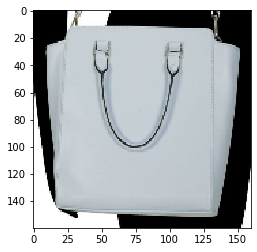

In [57]:
# Evaluate a single prediction
for imgs, _ in input_fn(test_data, is_eval=True).take(1):
    img_idx = 50
    plt.imshow(imgs["x"][img_idx] / 255)
    print(p[img_idx]['predicted_class'])

## Multi-task learning with the Head API

In [ ]:
# Need to disable the eager execution at this point
import numpy as np
import tensorflow as tf

In [ ]:
def multihead_input_fn(data, is_eval=False):
    features, labels = input_fn(data, is_eval=is_eval).make_one_shot_iterator().get_next() # Why?
    return features, {'head_nose': labels[:, 2:8:5], 'head_pose': tf.cast(labels[:, -1] - 1.0, tf.int32)}

In [ ]:
def multi_head_cnn_model_fn(features, labels, mode):

    dense = extract_features(features)

    # Predictions for each task
    predictions_nose = tf.layers.dense(inputs=dense, units=2)
    predictions_pose = tf.layers.dense(inputs=dense, units=5)
    logits = {'head_nose': predictions_nose, 'head_pose': predictions_pose}

    # Optimizer
    optimizer = tf.train.AdamOptimizer()

    # Double head
    regression_head = tf.contrib.estimator.regression_head(name='head_nose', label_dimension=2)
    classification_head = tf.contrib.estimator.multi_class_head(name='head_pose', n_classes=5)

    # Multi head combining two single heads
    multi_head = tf.contrib.estimator.multi_head([regression_head, classification_head])

    return multi_head.create_estimator_spec(features, mode, logits, labels, optimizer)

### Create the Estimator

In [ ]:
multitask_classifier = tf.estimator.Estimator(model_fn=multi_head_cnn_model_fn)

### Train & evaluate & test model

In [ ]:
# Train the model
multitask_classifier.train(input_fn=lambda: multihead_input_fn(train_data), steps=1000)

In [ ]:
multitask_classifier.evaluate(input_fn=lambda: multihead_input_fn(test_data, is_eval=True))

In [ ]:
p = list(multitask_classifier.predict(lambda: input_fn(test_data, is_eval=True)))
print(p[0])